Par Mohamed aziz cherif, hassen bouchhiwa, youssef jouili et Haroun Jaouadi

# TP 3 

## Importation des bibliothèques

In [16]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D, MaxPooling1D
from keras.layers import LSTM
from keras.layers import Embedding , GRU
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt 
import seaborn as sns

## Importation du dataset

In [17]:
movie_reviews = pd.read_csv('IMDB Dataset.csv')
movie_reviews.shape

(50000, 2)

In [18]:
movie_reviews.isna().sum()

review       0
sentiment    0
dtype: int64

In [19]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


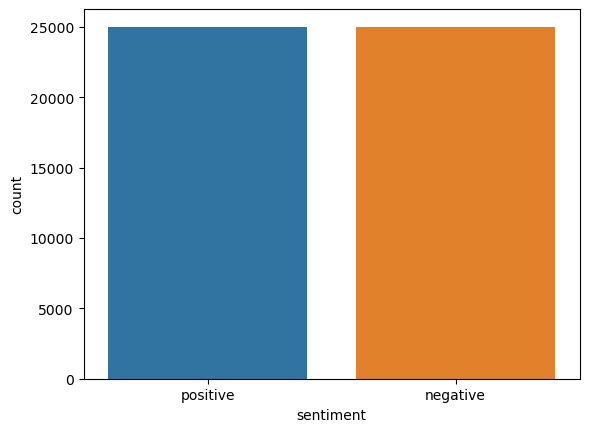

In [20]:
sns.countplot(data = movie_reviews , x='sentiment')
plt.show()

In [21]:
movie_reviews['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Notre dataset est bien équilibré

In [22]:
display(movie_reviews.iloc[3,:]['review'])
display(movie_reviews.iloc[3,:]['sentiment'])

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

'negative'

On remaque la présence des html tags qui sont inutiles pour nos données et doivent ètre supprimer

## Prétraitement de données

In [23]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence
#A regural expression that matches all html tags
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    #remove html tags from the variable text
    return TAG_RE.sub('', text)


Pour le code précedent, on a utilisé les expressions reguliéres pour filtrer nos données et supprimer les expressions inutiles comme les html tags, les punctuations, les numéros et les espaces

In [24]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
display(movie_reviews.iloc[3,:]['review'])

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

la fonction preprocess_text a bien nettoyé les reviews trouvé dans les données movie_reviews  

In [25]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=42)

## La couche de l'embedding

In [27]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


In [28]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [29]:
from numpy import array
from numpy import asarray
from numpy import zeros
embeddings_dictionary = dict()
glove_file = open("glove.6B.100d.txt", encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:],dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()


In [30]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## A. Classification avec un simple réseau de neurones

In [31]:
model = Sequential()

# Ajout de la couche Embedding
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# Ajout de la couche Flatten
model.add(Flatten())

# Ajout de la couche Dense
model.add(Dense(units=1, activation='sigmoid'))

# Compilation du modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entraînement du modèle
history=model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)


Epoch 1/6
250/250 [==============================] - 3s 4ms/step - loss: 0.5971 - acc: 0.6769 - val_loss: 0.5370 - val_acc: 0.7365
Epoch 2/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4931 - acc: 0.7640 - val_loss: 0.5371 - val_acc: 0.7297
Epoch 3/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4634 - acc: 0.7808 - val_loss: 0.5530 - val_acc: 0.7265
Epoch 4/6
250/250 [==============================] - 1s 3ms/step - loss: 0.4346 - acc: 0.8018 - val_loss: 0.5252 - val_acc: 0.7499
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4207 - acc: 0.8093 - val_loss: 0.5257 - val_acc: 0.7467
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4075 - acc: 0.8166 - val_loss: 0.5357 - val_acc: 0.7466


In [32]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.5370 - acc: 0.7436
Test Score: 0.5369867086410522
Test Accuracy: 0.7436000108718872


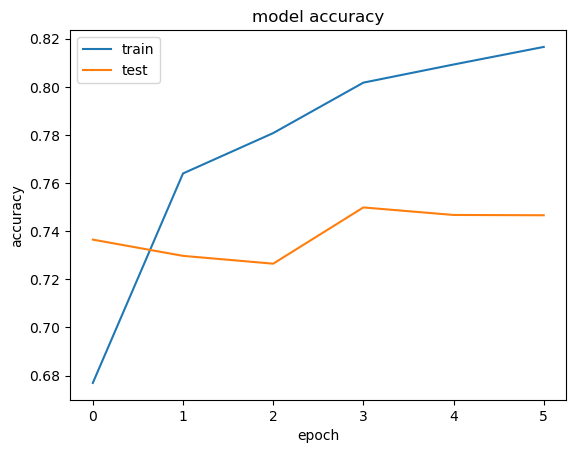

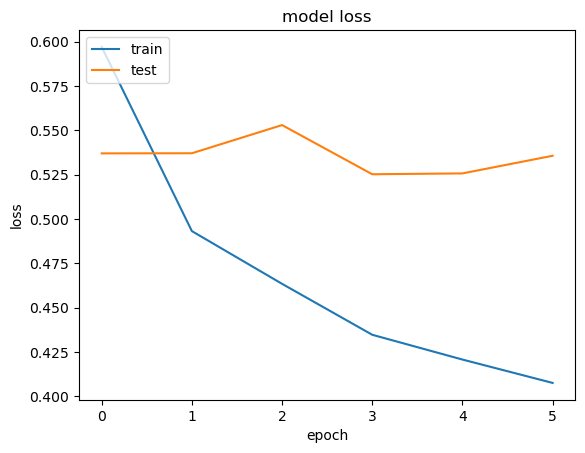

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

On remarque que pour l'époque 2, le modéle atteint une "accuarcy" maximale et une perte minimale. 

## B. Classification avec un réseau de neurones convolutionnel 

In [35]:
# Créer un modèle séquentiel
model = Sequential()

# Ajouter une couche Embedding
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False))

# Ajouter une couche Conv1D
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Ajouter une couche MaxPooling1D
model.add(MaxPooling1D())

# Ajouter une couche Dense
model.add(Dense(units=1, activation='sigmoid'))

# Compiler le modèle avec les paramètres donnés
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='acc')

# Entraîner le modèle avec les paramètres donnés
history = model.fit(X_train, np.reshape(y_train, (-1,1)), epochs=6, batch_size=128, validation_split=0.2, verbose=1)


Epoch 1/6
250/250 [==============================] - 8s 9ms/step - loss: 0.6659 - acc: 0.5890 - val_loss: 0.6519 - val_acc: 0.6095
Epoch 2/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6491 - acc: 0.6115 - val_loss: 0.6450 - val_acc: 0.6165
Epoch 3/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6441 - acc: 0.6171 - val_loss: 0.6416 - val_acc: 0.6202
Epoch 4/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6392 - acc: 0.6235 - val_loss: 0.6458 - val_acc: 0.6157
Epoch 5/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6366 - acc: 0.6268 - val_loss: 0.6444 - val_acc: 0.6200
Epoch 6/6
250/250 [==============================] - 2s 7ms/step - loss: 0.6345 - acc: 0.6291 - val_loss: 0.6379 - val_acc: 0.6237


In [36]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 2s 4ms/step - loss: 0.7589 - acc: 0.5038
Test Score: 0.7588545680046082
Test Accuracy: 0.5038445591926575


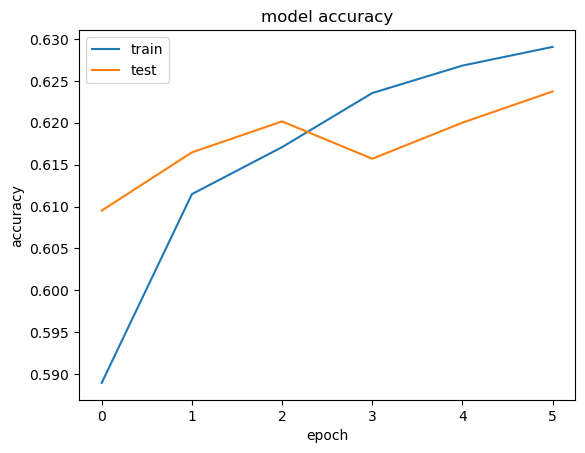

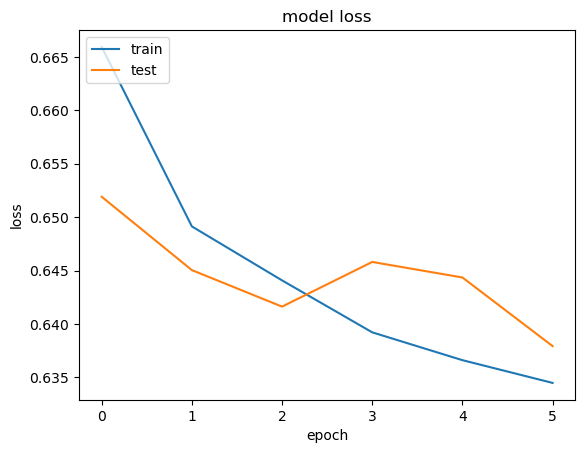

In [37]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## C. Classification avec un réseau de neurones récurrent (LSTM)

In [38]:
# Créer le modèle
model = Sequential()

# Ajouter la couche Embedding
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen))

# Ajouter la couche LSTM
model.add(LSTM(units=128))

# Ajouter la couche Dense
model.add(Dense(units=1, activation='sigmoid'))

# Compiler le modèle
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 12s 39ms/step - loss: 0.4969 - acc: 0.7529 - val_loss: 0.3579 - val_acc: 0.8435
Epoch 2/6
250/250 [==============================] - 9s 36ms/step - loss: 0.3351 - acc: 0.8574 - val_loss: 0.3328 - val_acc: 0.8609
Epoch 3/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2956 - acc: 0.8772 - val_loss: 0.3219 - val_acc: 0.8643
Epoch 4/6
250/250 [==============================] - 9s 37ms/step - loss: 0.2593 - acc: 0.8938 - val_loss: 0.3254 - val_acc: 0.8643
Epoch 5/6
250/250 [==============================] - 9s 37ms/step - loss: 0.2378 - acc: 0.9049 - val_loss: 0.3350 - val_acc: 0.8618
Epoch 6/6
250/250 [==============================] - 9s 37ms/step - loss: 0.2143 - acc: 0.9165 - val_loss: 0.3259 - val_acc: 0.8633


In [39]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.3081 - acc: 0.8676
Test Score: 0.30808618664741516
Test Accuracy: 0.8676000237464905


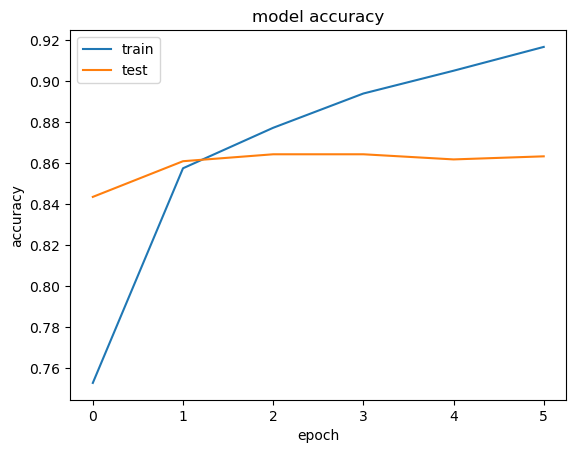

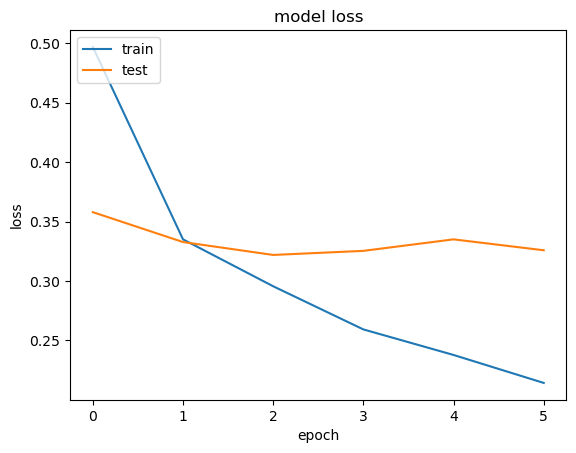

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [41]:
instance =X[80]
print(instance)

Stephen Hawkings is genius He is the king of geniuses Watching this movie makes me feel dumb But it a great movie Not highly entertaining but very very intriguing The movie centers around wheelchair bound Stephen Hawkings man who makes Einstein look average and his theories and scientific discoveries about the universe time the galaxy and black holes Everyone at sometime or another during really intense high comes to moment when they think they got the universe and the cosmos figured out and they swear as soon as they sober up they ll write it all down Well here is man who actually held that feeling for more then six hours Here is man who despite suffering from Lou Gehrig disease has become the greatest mind the world has yet seen Watch this and listen in on how he has formulated theories on black holes Awesome You won be the same after you see it 


In [42]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

prediction = model.predict(instance)

if(prediction>0.5):
    print('The instance is positive')
else: print('the instance is negative')

1/1 [==============================] - 0s 402ms/step
The instance is positive


La prédiction de ce modéle était correcte

# Compte Rendue

Au premier lieu, on va définir une fonction pour chaque modéle (LSTM, GRU et RNN+CNN) qui prend comme paramétres les données de test et de train (X_train, y_train, X_test, y_test) et retourne la précision (accuracy) correspondantesau test

In [43]:
#LSTM 
def train_and_evaluate_LTSM_model(embedding_matrix_method,embedding_dim=100):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix_method], input_length=maxlen))
    model.add(LSTM(units=128))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=6, batch_size=128, verbose=1, validation_split=0.2)
    score = model.evaluate(X_test, y_test, verbose=1)
    return score[1]


In [44]:
#GRU 
def train_and_evaluate_GRU_model(embedding_matrix_method, embedding_dim=100):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix_method], input_length=maxlen))
    model.add(GRU(32))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)
    score= model.evaluate(X_test, y_test)
    return score[1]

In [57]:
#RNN + CNN
def train_and_evaluate_RNN_CNN_model(embedding_matrix_method, embedding_dim=100):
    # define the model
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix_method], input_length=maxlen, trainable=False))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GRU(units=128))
    model.add(Dense(units=1, activation='sigmoid'))

    # compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=1, validation_split=0.2, )

    # evaluate the model on the test set
    score= model.evaluate(X_test, y_test)
    return score[1]

Au deuxiéme lieu, on va définir l'embedding_matrix_method à utiliser pour chaque méthod d"Embedding (Glove, Wor2vec, Fasttext et Tf-idf) 

In [46]:
#l'embedding_matrix qu'on était en train d'utiliser jusqu'à cette cell est celle du glove embedding donc on just l'enregistre dans une autre variable
embedding_matrix_glove= embedding_matrix
embedding_dim_glove=100

In [47]:
#Word2vec
from gensim.models import Word2Vec
w2v_model = Word2Vec(sentences=X, window=5, min_count=1)

In [48]:
embedding_matrix_w2v = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in enumerate(w2v_model.wv.key_to_index):
        embedding_matrix_w2v[i] = w2v_model[word]

In [49]:
from gensim.models import FastText
fasttext_model= FastText(sentences=X, min_count=1 , window=5)

In [50]:
# get the embedding matrix
embedding_matrix_fasttext = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = fasttext_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf.fit(X)

TfidfVectorizer()

In [52]:
vocab = tfidf.get_feature_names()
idf = tfidf.idf_
embedding_matrix_tfidf = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in vocab:
        tfidf_weight = idf[vocab.index(word)]
        embedding_matrix_tfidf[i] = tfidf.transform([word]).toarray()[0][:100] * tfidf_weight


C:\Users\Admin\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [58]:
results=pd.DataFrame()
results.index = ['LTSM', 'GRU', 'RNN + CNN']
results['Glove']= [train_and_evaluate_LTSM_model(embedding_matrix_glove), train_and_evaluate_GRU_model(embedding_matrix_glove),  train_and_evaluate_RNN_CNN_model(embedding_matrix_glove)]
results

Epoch 1/6
250/250 [==============================] - 11s 40ms/step - loss: 0.4821 - acc: 0.7654 - val_loss: 0.3717 - val_acc: 0.8418
Epoch 2/6
250/250 [==============================] - 9s 36ms/step - loss: 0.3346 - acc: 0.8575 - val_loss: 0.3254 - val_acc: 0.8609
Epoch 3/6
250/250 [==============================] - 9s 37ms/step - loss: 0.2813 - acc: 0.8843 - val_loss: 0.3168 - val_acc: 0.8641
Epoch 4/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2526 - acc: 0.8992 - val_loss: 0.3161 - val_acc: 0.8637
Epoch 5/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2336 - acc: 0.9087 - val_loss: 0.3344 - val_acc: 0.8636
Epoch 6/6
313/313 [==============================] - 2s 5ms/step - loss: 0.3304 - acc: 0.8657
Epoch 1/10
250/250 [==============================] - 9s 30ms/step - loss: 0.5430 - acc: 0.7037 - val_loss: 0.3597 - val_acc: 0.8420
Epoch 2/10
250/250 [==============================] - 7s 28ms/step - loss: 0.3234 - acc: 0.8612 - val_loss: 0.32

,Glove
LTSM,0.8657
GRU,0.8567
RNN + CNN,0.8281


In [59]:
results['Word2vec']=[train_and_evaluate_LTSM_model(embedding_matrix_w2v), train_and_evaluate_GRU_model(embedding_matrix_w2v),  train_and_evaluate_RNN_CNN_model(embedding_matrix_w2v)]


Epoch 1/6
250/250 [==============================] - 11s 39ms/step - loss: 0.4228 - acc: 0.7974 - val_loss: 0.3450 - val_acc: 0.8522
Epoch 2/6
250/250 [==============================] - 9s 37ms/step - loss: 0.2977 - acc: 0.8787 - val_loss: 0.3459 - val_acc: 0.8546
Epoch 3/6
250/250 [==============================] - 9s 37ms/step - loss: 0.2601 - acc: 0.8939 - val_loss: 0.3932 - val_acc: 0.8443
Epoch 4/6
250/250 [==============================] - 9s 37ms/step - loss: 0.2262 - acc: 0.9084 - val_loss: 0.3949 - val_acc: 0.8445
Epoch 5/6
250/250 [==============================] - 9s 37ms/step - loss: 0.1972 - acc: 0.9225 - val_loss: 0.3865 - val_acc: 0.8439
Epoch 6/6
313/313 [==============================] - 2s 6ms/step - loss: 0.4489 - acc: 0.8453
Epoch 1/10
250/250 [==============================] - 9s 30ms/step - loss: 0.4568 - acc: 0.7728 - val_loss: 0.3528 - val_acc: 0.8514
Epoch 2/10
250/250 [==============================] - 7s 28ms/step - loss: 0.3012 - acc: 0.8762 - val_loss: 0.33

In [60]:
results['Fasttext']=[train_and_evaluate_LTSM_model(embedding_matrix_fasttext), train_and_evaluate_GRU_model(embedding_matrix_fasttext),  train_and_evaluate_RNN_CNN_model(embedding_matrix_fasttext)]
results

Epoch 1/6
250/250 [==============================] - 14s 52ms/step - loss: 0.4203 - acc: 0.8048 - val_loss: 0.3531 - val_acc: 0.8499
Epoch 2/6
250/250 [==============================] - 9s 37ms/step - loss: 0.3030 - acc: 0.8765 - val_loss: 0.3340 - val_acc: 0.8574
Epoch 3/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2628 - acc: 0.8925 - val_loss: 0.3408 - val_acc: 0.8491
Epoch 4/6
250/250 [==============================] - 9s 38ms/step - loss: 0.2390 - acc: 0.9051 - val_loss: 0.3961 - val_acc: 0.8472
Epoch 5/6
250/250 [==============================] - 9s 38ms/step - loss: 0.2066 - acc: 0.9201 - val_loss: 0.4281 - val_acc: 0.8457
Epoch 6/6
313/313 [==============================] - 3s 8ms/step - loss: 0.4208 - acc: 0.8420
Epoch 1/10
250/250 [==============================] - 10s 31ms/step - loss: 0.4520 - acc: 0.7784 - val_loss: 0.3448 - val_acc: 0.8529
Epoch 2/10
250/250 [==============================] - 7s 29ms/step - loss: 0.2987 - acc: 0.8766 - val_loss: 0.3

,Glove,Word2vec,Fasttext
LTSM,0.8657,0.8453,0.8420
GRU,0.8567,0.8400,0.8429
RNN + CNN,0.8281,0.4961,0.7325


In [61]:
results['Tf-idf']=[train_and_evaluate_LTSM_model(embedding_matrix_tfidf), train_and_evaluate_GRU_model(embedding_matrix_tfidf),  train_and_evaluate_RNN_CNN_model(embedding_matrix_tfidf)]
results

Epoch 1/6
250/250 [==============================] - 11s 38ms/step - loss: 0.4071 - acc: 0.8111 - val_loss: 0.3502 - val_acc: 0.8546
Epoch 2/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2994 - acc: 0.8760 - val_loss: 0.3380 - val_acc: 0.8519
Epoch 3/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2692 - acc: 0.8885 - val_loss: 0.3751 - val_acc: 0.8428
Epoch 4/6
250/250 [==============================] - 9s 37ms/step - loss: 0.2341 - acc: 0.9061 - val_loss: 0.4068 - val_acc: 0.8447
Epoch 5/6
250/250 [==============================] - 9s 38ms/step - loss: 0.2082 - acc: 0.9180 - val_loss: 0.3880 - val_acc: 0.8475
Epoch 6/6
313/313 [==============================] - 2s 6ms/step - loss: 0.4437 - acc: 0.8500
Epoch 1/10
250/250 [==============================] - 10s 33ms/step - loss: 0.4614 - acc: 0.7704 - val_loss: 0.3509 - val_acc: 0.8478
Epoch 2/10
250/250 [==============================] - 7s 28ms/step - loss: 0.3087 - acc: 0.8727 - val_loss: 0.3

,Glove,Word2vec,Fasttext,Tf-idf
LTSM,0.8657,0.8453,0.8420,0.8500
GRU,0.8567,0.8400,0.8429,0.8447
RNN + CNN,0.8281,0.4961,0.7325,0.4961


On remarque que chaque modéle est plus performant pour une méthode d'Embedding spécifique.
Pour le LTSM, le Glove Embedding est le plus favorable avec une précision de test de 0.8657
Pour le GRU, le Glove Embedding est aussis le plus favorable avec une précision de test de 0.8567
Pour le RNN+CNN, le Fasttext Embedding est le plus favorable avec une précision de test de 0.7325